In [87]:
import numpy as np
import pandas as pd
import datetime
import pickle
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

In [2]:
## ADDITIONAL FUNCTIONS
if not os.path.exists('models'):
    os.makedirs('models')

pStopWordsList = stopwords.words('english') + stopwords.words('russian')
    
def process_text_layer(TextLayer, pStopWordsList = []):
    txt =  " ".join([w for w in TextLayer.lower().split() \
                     if (not w in pStopWordsList)])

    txt = txt. \
        replace('«', ''). \
        replace('»', ''). \
        replace('(', ''). \
        replace(')', ''). \
        replace('\[)', ''). \
        replace('\]', ''). \
        replace('^', ''). \
        replace('\\', '')

    return txt

def learnBinaryClassifier(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model

In [5]:
text_data = pd.read_csv('CLASS PROSPECTUS.csv')
text_data['string_value'] = text_data['string_value'].astype(str)
class_data = pd.read_excel('CLASS PROSPECTUS.xlsx', sheet_name = 'DATA')

models_rename = {
    "Ограничение по предоставлению залога":"Restriction_on_the_provision_of_collateral",
    "Изменение контроля":"Change_of_control",
    "Случаи дефолта":"Cases_of_default",
    "Кросс-дефолт":"Cross-default",
    "Оговорки о коллективных действиях":"Collective_action_clauses",
    "Ограничение задолженности":"Limitation_on_indebtedness",
    "Ограничение задолженности дочерних компаний":"Limitation_of_debt_of_subsidiaries",
    "Ограничение по платежам":"Limitation_on_payments",
    "Ограничение по инвестициям":"Investment_restriction",
    "Ограничение по платежам в отношении дочерних компаний":"Limitation_on_payments_to_subsidiaries",
    "Ограничение по транзакциям с аффилированными лицами":"Restriction_on_transactions_with_affiliates",
    "Ограничение деятельности":"Restriction_of_activity",
    "Ограничение по продаже активов":"Restriction_on_asset_sales",
    "Ограничение по продаже активов с обратной арендой":"Restriction_on_the_sale_of_assets_with_leaseback",
    "Ограничение по слиянию":"Limitation_on_merger",
    "Триггер рейтингов":"Ratings_trigger",
    "Обозначение прав дочерних компаний (restricted / unrestricted)":"Designation_of_the_rights_of_subsidiaries",
    "Ограничение по наслоению долговых обязательств по рангам":"Restriction_on_the_layering_of_debt_obligations_by_rank",
    "Условие приостановки действия ковенантов":"A_condition_of_suspension_of_the_covenants",
    "Финансовые ковенанты":"Financial_covenants"}
class_data = class_data.rename(columns=models_rename)

In [6]:
# Уменьшаем размерность задачи, так как слишком много нулевых данных
tags = list(class_data['tag'])
new_tags = list(text_data[~text_data['tag'].isin(tags)].sample(3000)['tag'])
new_tags = new_tags + tags
text_data = text_data[text_data['tag'].isin(new_tags)]

In [7]:
data = text_data.merge(class_data, on='tag', how='left').copy()
data['string_value'] = data.apply(lambda r: process_text_layer(r['string_value'], pStopWordsList), axis = 1)
models = list(data.columns)[2:]

In [74]:
datasets[models[0]]['df_training']["x"][10]

'considers whether technical, market, economic, legal environment investee operates significant adverse changes determine whether equity instrument impaired. available-for-sale financial asset fair value impaired, cumulative loss arising decline fair value recognized directly comprehensive income reclassified impairment loss. if, impairment loss recognized available-for-sale debt instrument investment, objective evidence recovery value financial asset related objectively event occurring impairment recognized, previously recognized impairment loss reversed profit loss. subsequent fair value increase available-for-sale debt instrument investment whose impairment loss recognized directly recognized comprehensive income. available-for-sale equity instrument cost impaired, impairment loss equity instrument investment recognized excess carrying amount present value future cash flows, impairment loss reversed upon recognition. ix receivables 1. receivables individually significant amount prov

In [54]:
datasets = {}
#models = ['Change_of_control']
for model_name in models:
    ds = data[['tag','string_value', model_name]].rename(columns={'string_value': 'x', model_name: 'target'})
    ds = ds.fillna(0)
    ds = ds[ds['target']!=''].drop_duplicates()
    datasets[model_name] = ds.copy()

/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pa

In [56]:
validation_set_part = 0.2
for model_name in models:
    df = datasets[model_name]
    df_validation = df.sample(frac = validation_set_part) 
    df_training = df.drop(df_validation.index) 
    item = {
        'df_validation': df_validation.copy(),
        'df_training': df_training.copy()
    }
    datasets[model_name] = item

In [58]:
for model_name in models:
    vector, model = learnBinaryClassifier(datasets[model_name]['df_training'])
    with open(('./models\\CLASS_PROSPECTUS_%s.rft' % model_name), 'wb') as f:
        pickle.dump(model, f)
    with open(('./models\\VECTOR_PROSPECTUS_%s.txt' % model_name), 'wb') as f:
        pickle.dump(vector, f)

Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Trans

In [99]:
confidence_level = 0.5
for model_name in models:
    with open(('./models\\CLASS_PROSPECTUS_%s.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('./models\\VECTOR_PROSPECTUS_%s.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
        
    ds = datasets[model_name]['df_validation']
    
    ds['predict']= model.predict(vector.transform(ds['x']))

    ds['confidence']=np.transpose(np.amax(model.predict_proba(vector.transform(ds['x'])), axis=1))
    ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
    
    precision = round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)
    to_validate = round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)
    
    print('Model %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision, to_validate, confidence_level))

Model Restriction_on_the_provision_of_collateral statistic (validation rows 685): Precision= 98.54 ; To_Validate=0.0  at Confidence=0.5
Model Change_of_control statistic (validation rows 685): Precision= 99.42 ; To_Validate=0.0  at Confidence=0.5
Model Cases_of_default statistic (validation rows 685): Precision= 99.56 ; To_Validate=0.0  at Confidence=0.5
Model Cross-default statistic (validation rows 685): Precision= 98.69 ; To_Validate=0.0  at Confidence=0.5
Model Collective_action_clauses statistic (validation rows 685): Precision= 98.83 ; To_Validate=0.0  at Confidence=0.5
Model Limitation_on_indebtedness statistic (validation rows 685): Precision= 100.0 ; To_Validate=0.0  at Confidence=0.5
Model Limitation_of_debt_of_subsidiaries statistic (validation rows 685): Precision= 99.71 ; To_Validate=0.0  at Confidence=0.5
Model Limitation_on_payments statistic (validation rows 685): Precision= 99.85 ; To_Validate=0.0  at Confidence=0.5
Model Investment_restriction statistic (validation ro

In [103]:
confidence_level = 0.5
for model_name in models:
    with open(('./models\\CLASS_PROSPECTUS_%s.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('./models\\VECTOR_PROSPECTUS_%s.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
        
    ds = datasets[model_name]['df_validation']
    
    temp = model.predict_proba(vector.transform(ds['x']))
  
    temptemp = [a for a,b in temp]
    try:
        first, second = (confusion_matrix(ds["target"], ds["predict"]))
    except:
        print(ds["target"])
        print(ds["predict"])
    tn, fn = first
    fp, tp = second
    print (f"Covenant ratio = {(tp + fn) / (fp + tn)}, Model name = {model_name}, true_positive = {tp / (tp + fn)}, true_negative = {tn / (tn + fp)}")



Covenant ratio = 0.011816838995568686, Model name = Restriction_on_the_provision_of_collateral, true_positive = 0.875, true_negative = 0.9867060561299852
Covenant ratio = 0.005873715124816446, Model name = Change_of_control, true_positive = 1.0, true_negative = 0.9941262848751835
Covenant ratio = 0.02391629297458894, Model name = Cases_of_default, true_positive = 1.0, true_negative = 0.9955156950672646
Covenant ratio = 0.005873715124816446, Model name = Cross-default, true_positive = 0.75, true_negative = 0.9882525697503671
Covenant ratio = 0.013313609467455622, Model name = Collective_action_clauses, true_positive = 1.0, true_negative = 0.9881656804733728
Covenant ratio = 0.0014619883040935672, Model name = Limitation_on_indebtedness, true_positive = 1.0, true_negative = 1.0
Covenant ratio = 0.0014619883040935672, Model name = Limitation_of_debt_of_subsidiaries, true_positive = 1.0, true_negative = 0.9970760233918129
Covenant ratio = 0.0014619883040935672, Model name = Limitation_on_p

ValueError: not enough values to unpack (expected 2, got 1)

In [30]:
def precision_count(ds, confidence_level):
    return round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)

In [33]:
def to_validate_count(ds, confidence_level):
    return round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)

In [47]:
def get_plot_points(ds):
    precisions = []
    to_validates = []
    confidences = [i / 100 for i in range(1,102,1)]
    for confidence_level in range(1, 102, 1):
        confidence_level /= 100
        precision = precision_count(ds, confidence_level)
        to_validate = to_validate_count(ds, confidence_level)
        precisions.append(precision)
        to_validates.append(to_validate)
    return precisions, to_validates, confidences

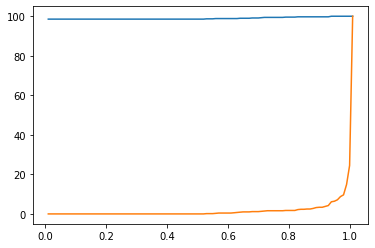

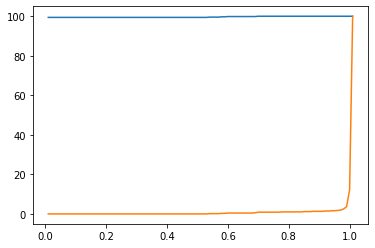

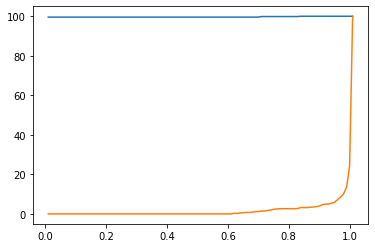

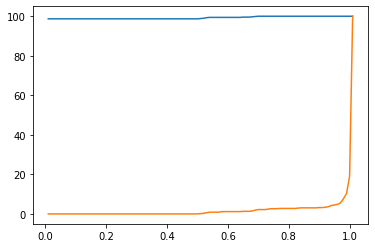

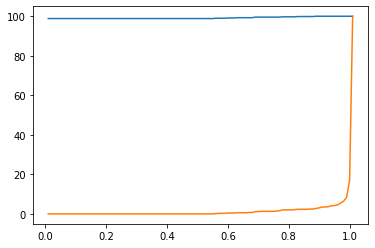

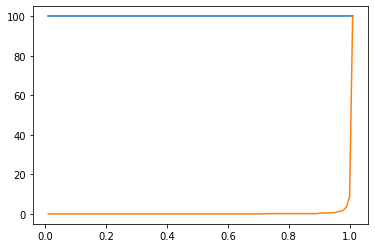

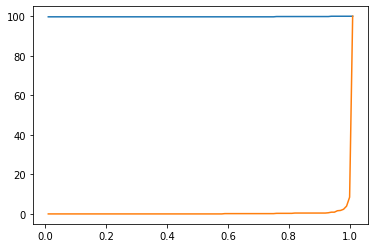

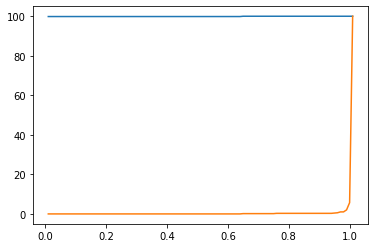

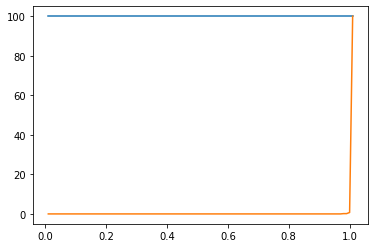

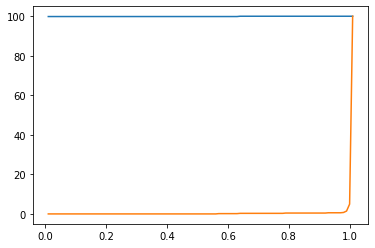

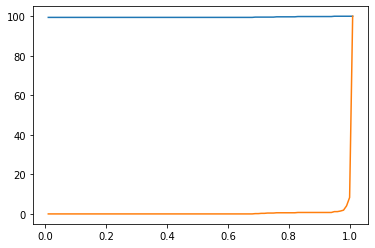

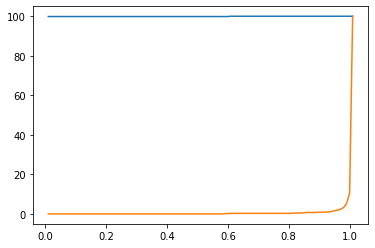

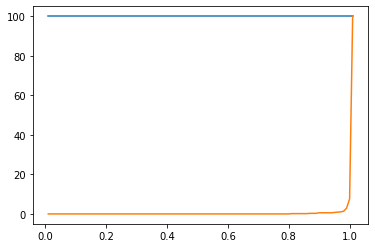

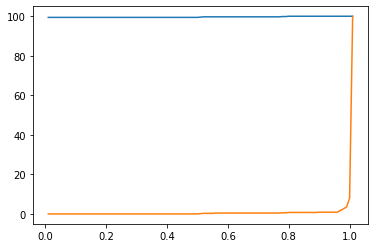

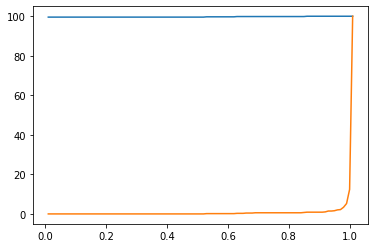

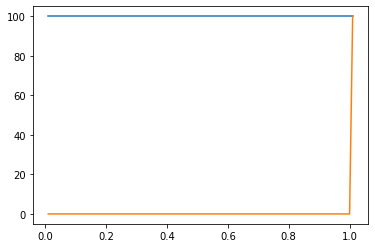

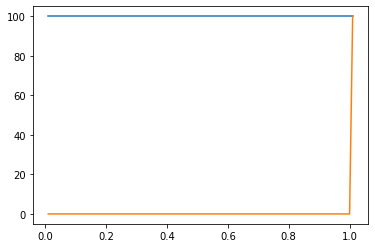

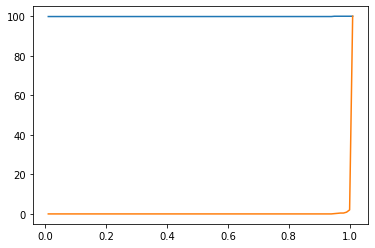

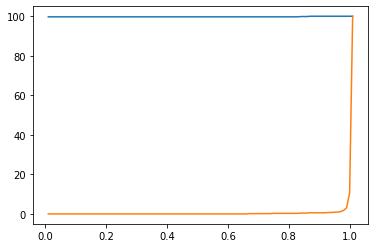

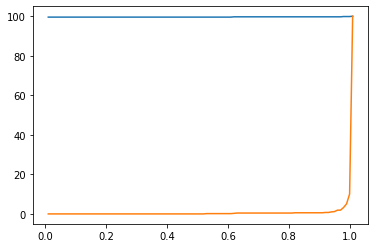

In [64]:
import matplotlib.pyplot as plt
for index, model_name in enumerate(models):
    ds = datasets[model_name]['df_validation']
    plt.figure(index)
    precision, to_validate, confidences = get_plot_points(ds)
    plt.plot(confidences,precision, label = "precision")
    plt.plot(confidences, to_validate, label = "to validate")

    